In [71]:
import pandas as pd
from tqdm.notebook import tnrange, tqdm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.preprocessing import MinMaxScaler

import torch
import torchvision
from torch.utils.data import Dataset, TensorDataset
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models

In [72]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## The Model :

In [73]:
model_ft = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)

network = model_ft.to(device)
#print(network)

In [74]:
path_to_model = './model_res18_94.pt'
network.load_state_dict(torch.load(path_to_model, map_location={'cuda:0': 'cpu'}))

<All keys matched successfully>

In [75]:
kaggle_test_csv_path='../input/state-farm-distracted-driver-detection/sample_submission.csv'
test_csv_path='./state-farm-distracted-driver-detection/sample_submission.csv'
df_test=pd.read_csv(test_df_path)
df_test

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
1,img_10.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2,img_100.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
3,img_1000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
4,img_100000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
...,...,...,...,...,...,...,...,...,...,...,...
79721,img_99994.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
79722,img_99995.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
79723,img_99996.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
79724,img_99998.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


In [76]:
class test_Dataset(Dataset):
    """custom"""

    def __init__(self, csv_file_path, root_dir, transform=None):
        
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.transform = transform
        self.root_dir = root_dir
        self.d = pd.read_csv(csv_file_path, header= None)[1:]
    

        
    def __getitem__(self, idx): 
        smol_img_path = str(self.d.iloc[idx][0])
        full_img_path = self.root_dir + '/' + smol_img_path
        img_arr = image_to_nparray(full_img_path)

        if self.transform is not None:
            img_arr = self.transform(img_arr)
        
        return img_arr, int(idx)
        
        

    def __len__(self):
        return (len(self.d))

In [77]:
def image_to_nparray(path):
    i = plt.imread(path)    
    return(np.array(i))

In [93]:
kaggle_test_csv_path='../input/state-farm-distracted-driver-detection/sample_submission.csv'
test_csv_path='./state-farm-distracted-driver-detection/sample_submission.csv'
kaggle_test_imgs_path='../input/state-farm-distracted-driver-detection/imgs/test'
test_imgs_path='./state-farm-distracted-driver-detection/imgs/test'


test_data = test_Dataset(test_csv_path, 
               test_imgs_path,
                transform = transforms.Compose([
                                                transforms.ToPILImage(),
                                                transforms.Resize((224,224), interpolation=2),
                                                transforms.ToTensor(),
                                                #AddGaussianNoise(0., 0.05)
                                                ])
                )

print("Number of test images:", len(test_data))

Number of test images: 79726


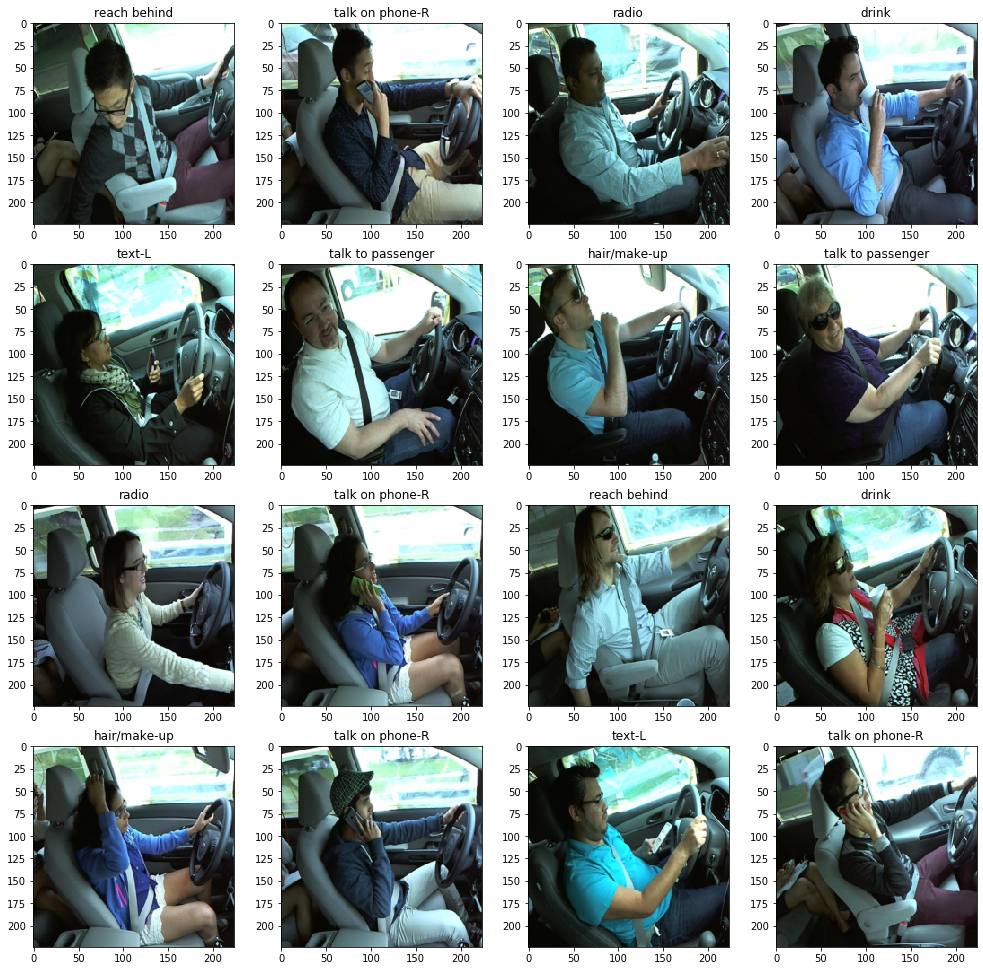

<Figure size 3600x3600 with 0 Axes>

In [94]:
test_loader = torch.utils.data.DataLoader(
     test_data
    ,batch_size=1
    ,shuffle=True
)

class_list = ['safe', 'text-R', 'talk on phone-R', 'text-L', 'talk on phone-L', 'radio', 'drink'
, 'reach behind', 'hair/make-up', 'talk to passenger']
fig, axs = plt.subplots(4, 4, figsize=(17,17))
plt.figure(figsize=(50,50))

for i in range(4):
    for j in range(4):
        for images, idx in (test_loader):
            
            x=np.transpose(images[0], (1, 2, 0))  
            axs[j,i].imshow(x, interpolation='none')
            
            with torch.no_grad():

                network.eval()
                images = images.to(device)
                lab=network(images[0].unsqueeze(0))
                lab = lab.cpu()
                max_index = np.argmax(lab[0]) 
                predicted_label = class_list[max_index]
            
            axs[j,i].title.set_text(predicted_label)
            break
plt.show()

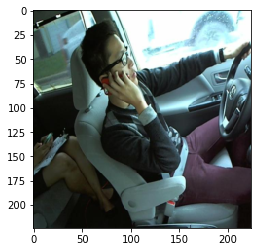

Predicted class: talk on phone-R


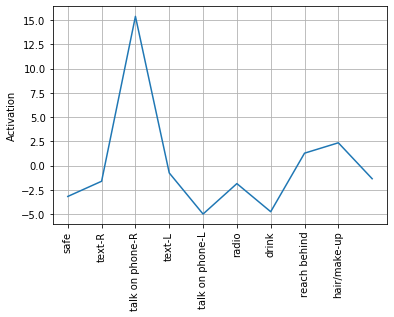

In [95]:
for image in (test_loader):
    images=images.cpu()
    x=np.transpose(images[0], (1, 2, 0))  
    plt.imshow(x, interpolation='none')
    plt.show()
    
    with torch.no_grad():

        network.eval()
        images = images.to(device)
        lab=network(images[0].unsqueeze(0))
        lab = lab.cpu()
        #print(lab[0])
        max_index = np.argmax(lab[0]) 
        predicted_label = class_list[max_index]
        print('Predicted class:', predicted_label)
        break

plt.plot(lab[0])
plt.grid()
plt.xticks([i for i in range(9)], class_list, rotation='vertical')
plt.ylabel('Activation')
plt.show()


In [96]:
kaggle_submission_csv_path = '../input/state-farm-distracted-driver-detection/sample_submission.csv'
submission_csv_path = './state-farm-distracted-driver-detection/sample_submission.csv'

sub = pd.read_csv(submission_csv_path)
sub

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
1,img_10.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2,img_100.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
3,img_1000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
4,img_100000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
...,...,...,...,...,...,...,...,...,...,...,...
79721,img_99994.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
79722,img_99995.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
79723,img_99996.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
79724,img_99998.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


In [97]:
test_loader_no_shuffle = torch.utils.data.DataLoader(
     test_data
    ,batch_size=1
    ,shuffle=False
)

In [99]:
for images, idx in tqdm(test_loader_no_shuffle):
    

    with torch.no_grad():
        
        network.eval()
        images = images.to(device)
        lab=network(images[0].unsqueeze(0))
        lab = lab.cpu()

    things = lab[0]    

    sub.at[idx, 'c0'] = things[0].item()
    sub.at[idx, 'c1'] = things[1].item()
    sub.at[idx, 'c2'] = things[2].item()
    sub.at[idx, 'c3'] = things[3].item()
    sub.at[idx, 'c4'] = things[4].item()
    sub.at[idx, 'c5'] = things[5].item()
    sub.at[idx, 'c6'] = things[6].item()
    sub.at[idx, 'c7'] = things[7].item()
    sub.at[idx, 'c8'] = things[8].item()
    sub.at[idx, 'c9'] = things[9].item() 

In [100]:
copy_sub=sub

In [101]:
def scale_bw_0_1(df, immune_col):
    img_backup = df[immune_col]
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df[['c0', 'c1','c2','c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']]), columns = df[['c0', 'c1','c2','c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']].columns)
    df_scaled[immune_col] = img_backup #restore values
    
    return(df_scaled)

In [103]:
scaled_sub = scale_bw_0_1(copy_sub, 'img')
scaled_sub

In [105]:
scaled_sub.to_csv('submission_1.csv', index=False)